In [2]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from communicative_agent import CommunicativeAgent
from quantizer.quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils
import pickle

QUANTIZERS_PATH = "../out/quantizer"

In [12]:
ABX_NB_SAMPLES = 500
#AGENT_ABX_DISTANCES = [
#    {
#        "sound_units": {
#            "metric": "cosine",
#            "weight": 1,
#        }
#    },
#    {
#        "art_units": {
#            "metric": "cosine",
#            "weight": 1,
#        },
#    }
#]

AGENT_ABX_DISTANCES = [
    {
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        }
    },
    {
        "art_units": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]

In [13]:
#agents_path = glob("../out/communicative_agent/*/")
#agents_path.sort()
#agents_path = ['../out/communicative_agent/to_keep_50_n_layers_1_right_test/22e9cdcab1563dd5a97cce718987db69-0',
#              '../out/communicative_agent/to_keep_50_n_layers_1_right_test/a7e52eb520894e371afa9e349124bd4d-0',
#              '../out/communicative_agent/to_keep_50_n_layers_1_right_test/b8c532ecf618116ad1f06d5a341da3ae-0',
#              '../out/communicative_agent/to_keep_50_n_layers_1_right_test/188cb52ac1fc23257dba472730c07ba7-0']

#agents_path = ['../out/communicative_agent/Submission_CoLing/62f8def558c460813f27cf80a64eab2b-0', # 0.5,0.5
#               '../out/communicative_agent/Submission_CoLing/2ac538e9286d27b697a1228522f55e7b-0', # 0,0.5
#               '../out/communicative_agent/Submission_CoLing/8273c50bfe4dadaf41422822465c5799-0', # 0.5,0
#               '../out/communicative_agent/Submission_CoLing/12c2baf464b1696ea935fe9d4445f0f1-0'] # 0,0

#quantizers_path = ['../out/quantizer/Submission_CoLing/5379108e838758696b3e788677143eb4-0',
#              '../out/quantizer/Submission_CoLing/7c3e0287ebbe0b7d743ff31d53eee21b-0',
#              '../out/quantizer/Submission_CoLing/537c0b75e2efc1e3cf36d2972e37c377-0',
#              '../out/quantizer/Submission_CoLing/07d3970697611b3fc611fb6b986c6f68-0']

agents_path = ['../out/communicative_vs_imitative/communicative_jerk_gan_0',
               '../out/communicative_vs_imitative/communicative_jerk_gan_1',
               '../out/communicative_vs_imitative/communicative_jerk_gan_2',
               '../out/communicative_vs_imitative/communicative_jerk_gan_3',
               '../out/communicative_vs_imitative/communicative_jerk_gan_4']
# these are art quantizers
quantizers_path = ['../out/quantizer/communicative_jerk_gan_0',
                   '../out/quantizer/communicative_jerk_gan_1',
                   '../out/quantizer/communicative_jerk_gan_2',
                   '../out/quantizer/communicative_jerk_gan_3',
                   '../out/quantizer/communicative_jerk_gan_4']
agents_path = [ag for ag in agents_path if ag.split('/')[-2] != "classic"]
print(agents_path)
agents_alias = {}

for agent_path in agents_path:
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
    agent_alias = " ".join((
        #f"{','.join(config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"discrimination_loss={config['training']['discriminator_loss_weight']}",
        f"jerk={config['training']['jerk_loss_weight']}",
        f"patience={config['training']['patience']}",
        f"quantizer={config['sound_quantizer']}",
    ))
    
    agents_alias[agent_alias] = agent_path


['../out/communicative_vs_imitative/communicative_jerk_gan_0', '../out/communicative_vs_imitative/communicative_jerk_gan_1', '../out/communicative_vs_imitative/communicative_jerk_gan_2', '../out/communicative_vs_imitative/communicative_jerk_gan_3', '../out/communicative_vs_imitative/communicative_jerk_gan_4']


In [14]:
import os
agents_abx_matrices = utils.pickle_load("../out/communicative_vs_imitative/abx_cache.pickle", {})
# agents_abx_matrices = {}

i=0
for agent_alias, agent_path in tqdm(agents_alias.items()):
    agent = CommunicativeAgent.reload(agent_path)
    main_dataset = Dataset(agent.sound_quantizer.config['dataset']['names'][0])
    agent.config['dataset'] = {}
    agent.config['dataset']["names"] = ["pb2007"]
    agent.config['dataset'] = agent.sound_quantizer.config['dataset']
    agent.config['dataset']['sound_type'] = 'cepstrum'
    #print("agent %s with quantizer %s" % (os.path.basename(agent_path), os.path.basename(quantizers_path[i])))
    agent.art_quantizer = Quantizer.reload(quantizers_path[i],load_nn=True)
    agent.nn.art_quantizer = agent.art_quantizer.nn
    agent_lab = agent.sound_quantizer.get_datasplit_lab(2)
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    i+=1
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        agent_features = agent.repeat_datasplit(2)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES)
        groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
        global_score = abx_utils.get_global_score(abx_matrix)
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/communicative_vs_imitative/abx_cache.pickle", agents_abx_matrices)

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# Print ABX
for distance in AGENT_ABX_DISTANCES:
    abx_manner = []
    abx_place = []
    abx_global = []
    for agent_alias, agent_path in tqdm(agents_alias.items()):
        distance_signature = abx_utils.get_distance_signature(distance)
        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
        global_score = abx_utils.get_global_score(agent_abx_matrix)
        abx_manner.append(groups_score['manner'])
        abx_place.append(groups_score['place'])
        abx_global.append(global_score)
    print(f"Communicative agent, {distance}")
    print(f'N={len(abx_global)}')
    print('ABX place : mu=%.1f, std=%.1f' % (np.mean(abx_place), np.std(abx_place, ddof=1)))
    print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(abx_manner), np.std(abx_manner, ddof=1)))
    print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(abx_global), np.std(abx_global, ddof=1)))
    print(abx_place)

  0%|          | 0/5 [00:00<?, ?it/s]

Communicative agent, {'art_estimated': {'metric': 'cosine', 'weight': 1}}
N=5
ABX place : mu=61.9, std=8.7
ABX manner: mu=73.3, std=10.0
ABX global: mu=75.0, std=8.8
[59.925000000000004, 68.68333333333334, 48.791666666666664, 61.308333333333344, 70.72500000000001]


  0%|          | 0/5 [00:00<?, ?it/s]

Communicative agent, {'art_units': {'metric': 'cosine', 'weight': 1}}
N=5
ABX place : mu=56.6, std=12.7
ABX manner: mu=64.9, std=13.1
ABX global: mu=66.6, std=14.7
[38.916666666666664, 68.82499999999999, 49.6, 57.40833333333333, 68.15833333333333]


cepstrum {'manner': 88.68333333333332, 'place': 62.56666666666667}


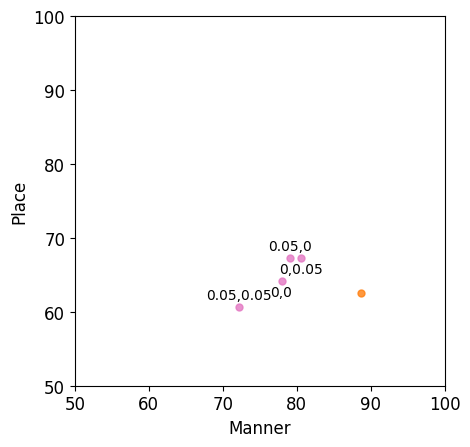

In [93]:
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

colors = {
    "sound_units": "tab:orange",
    "art_units": "tab:pink",
}
plt.figure()
ax = plt.subplot(aspect="equal")
ax.set_xlim(50, 100)
ax.set_ylim(50, 100)
ax.set_xlabel("Manner")
ax.set_ylabel("Place")

i=0
done = False
for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    for agent_alias, agent_path in agents_alias.items():
        agent = CommunicativeAgent.reload(agent_path, load_nn=False)
        dataset = Dataset(agent.sound_quantizer.config['dataset']['names'][0])
        consonants = dataset.phones_infos["consonants"]
        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, dataset.phones_infos["consonant_groups"])
        modality = list(distance.keys())[0]
        color = colors[modality]
        if modality == 'sound_units' and not done or modality == 'art_units':
            ax.scatter(agent_groups_score["manner"], agent_groups_score["place"], c=color, alpha=.8)
            done = True
            if modality == 'sound_units':
                print("cepstrum", agent_groups_score)
        discrimination_loss_weight = agent_alias.split(' ')[1].replace('discrimination_loss=', '')
        jerk_loss_weight = agent_alias.split(' ')[2].replace('jerk=', '')
        if modality == 'art_units':
            if i % 2 == 1:
                shift = -2#*(len(discrimination_loss_weight)+len(jerk_loss_weight))
            else:
                shift = 1#*(len(discrimination_loss_weight)+len(jerk_loss_weight))
            label = f"{jerk_loss_weight},{discrimination_loss_weight}"
            ax.text(agent_groups_score["manner"], agent_groups_score["place"]+shift, 
                    label, horizontalalignment='center', fontsize=10)
            i += 1
plt.savefig('/home/engaclew/agent/out/communicative_agent/abx_place_manner_discrimination.png', dpi=300)

In [3]:
import pandas as pd

distance = AGENT_ABX_DISTANCES[1]
distance_signature = abx_utils.get_distance_signature(distance)

agents_loss = {
    "path": [],
    "datasets": [],
    "discrimination_loss_weight": [],
    "jerk_loss_weight": [],
    "direct_model_error": [],
    "inverse_error": [],
    "discrimination_loss": [],
    "jerk_loss": [],
    "abx_global": [],
    "abx_manner": [],
    "abx_place": []
}

for agent_alias, agent_path in tqdm(agents_alias.items()):
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    main_dataset = Dataset(agent.sound_quantizer.config['dataset']['names'][0])
    agent.config['dataset'] = {}
    agent.config['dataset']["names"] = ["pb2007"]
    agent.config['dataset'] = agent.sound_quantizer.config['dataset']
    agent.config['dataset']['sound_type'] = 'cepstrum'
    
    # Load logs in dictionnary
    agents_loss['path'].append(agent_path)
    agents_loss['datasets'].append(",".join(agent.sound_quantizer.config['dataset']['names']))
    agents_loss['discrimination_loss_weight'].append(agent.config['training']['discriminator_loss_weight'])
    agents_loss['jerk_loss_weight'].append(agent.config['training']['jerk_loss_weight'])
    with open("%s/metrics.pickle" % agent_path, "rb") as f:
        metrics = pickle.load(f)
    final_loss_index = np.argmin(metrics['validation']['inverse_model_repetition_error'])
    agents_loss['direct_model_error'].append(metrics['test']['direct_model_estimation_error'][final_loss_index])
    agents_loss['inverse_error'].append(metrics['test']['inverse_model_estimation_error'][final_loss_index])
    agents_loss['discrimination_loss'].append(metrics['test']['fool_discrimination_loss'][final_loss_index])
    agents_loss['jerk_loss'].append(metrics['test']['inverse_model_jerk'][final_loss_index])
    
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    
  
    abx_matrix = agents_abx_matrices[agent_path][distance_signature]
    groups_score = abx_utils.get_groups_score(consonants, abx_matrix, dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(abx_matrix)
    agents_loss["abx_manner"].append(groups_score["manner"])
    agents_loss["abx_place"].append(groups_score["place"])
    agents_loss["abx_global"].append(global_score)
    agent_abx_matrices[distance_signature] = abx_matrix

agents_loss = pd.DataFrame(agents_loss)

NameError: name 'AGENT_ABX_DISTANCES' is not defined

In [12]:
import pandas as pd

datasets = pd.unique(agents_loss["datasets"])

def show_top_agents(measure="abx_global", datasets=datasets[0], ascending=False):
    subset = agents_loss[agents_loss["datasets"] == datasets]
    display(subset.sort_values(measure, ascending=ascending).head(30))

ipw.interactive(show_top_agents, measure=agents_loss, datasets=datasets, ascending=False)

interactive(children=(Dropdown(description='measure', index=8, options=('path', 'datasets', 'discrimination_lo…

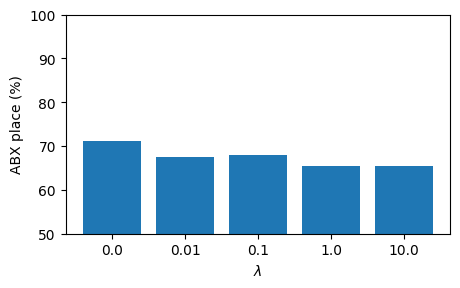

In [13]:
agents_loss = agents_loss.sort_values(by='discrimination_loss_weight')


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(11.4*cm,7.04*cm), constrained_layout=True)

h = agents_loss['abx_place']
x = range(0,len(h))
ax.bar(x=x, height=h)
ax.set_xticks(x)
ax.set_xticklabels(agents_loss['discrimination_loss_weight'].values)
ax.set_ylabel("ABX place (%)")
ax.set_xlabel("$\lambda$")
ax.set_ylim(50, 100)
plt.savefig('/home/engaclew/agent/out/communicative_agent/ABX_place_discrimination_loss.png', dpi=300)

In [2]:
import random

from lib.dataset_wrapper import Dataset

TEST_ITEMS = {
    "pb2007": [
        "item_0000",
        "item_0001",
        "item_0002",
        "item_0003",
        "item_0004",
        "item_0005",
        "item_0006",
        "item_0007",
        "item_0010",
        "item_0331",
        "item_0332",
        "item_0333",
        "item_0334",
        "item_0335",
        "item_0338",
        "item_0339",
        "item_0340",
        "item_0341",
        "item_0342",
        "item_0392",
        "item_0393",
        "item_0394",
        "item_0395",
        "item_0396",
        "item_0397",
        "item_0398",
        "item_0399",
        "item_0400",
        "item_0401",
        "item_0427",
        "item_0428",
        "item_0429",
        "item_0433",
        "item_0434",
        "item_0435",
        "item_0436",
        "item_0437",
        "item_0438",
        "item_0439",
    ]
}
SPLITS_SIZE = [64, 16, 20]

datasplits = {}
for dataset_name, test_items in TEST_ITEMS.items():
    dataset = Dataset(dataset_name)
    dataset_items = dataset.get_items_name("cepstrum")
    nb_items = len(dataset_items)
    for test_item in test_items:
        dataset_items.remove(test_item)
    random.shuffle(dataset_items)

    train_set_len = round(nb_items / 100 * SPLITS_SIZE[0])
    validation_set_len = round(nb_items / 100 * SPLITS_SIZE[1])
    train_set = dataset_items[:train_set_len]
    dataset_items = dataset_items[train_set_len:]
    validation_set = dataset_items[:validation_set_len]
    dataset_items = dataset_items[validation_set_len:]
    test_set = [*test_items, *dataset_items]
    datasplits[dataset_name] = [train_set, validation_set, test_set]
print(datasplits)
# quantizer.datasplits = datasplits


{'pb2007': [['item_0432', 'item_0071', 'item_0318', 'item_0566', 'item_0256', 'item_0656', 'item_0517', 'item_0084', 'item_0033', 'item_0856', 'item_0362', 'item_0337', 'item_1025', 'item_0860', 'item_0221', 'item_0913', 'item_0430', 'item_0285', 'item_0876', 'item_0636', 'item_0523', 'item_0510', 'item_0138', 'item_1059', 'item_0689', 'item_0019', 'item_0403', 'item_0565', 'item_0588', 'item_0841', 'item_0278', 'item_0861', 'item_0269', 'item_0792', 'item_0713', 'item_1107', 'item_0168', 'item_0601', 'item_0570', 'item_0075', 'item_0742', 'item_0745', 'item_0032', 'item_0726', 'item_0134', 'item_1055', 'item_0988', 'item_0825', 'item_0296', 'item_0921', 'item_0894', 'item_0416', 'item_0053', 'item_0457', 'item_0413', 'item_0066', 'item_0100', 'item_0363', 'item_0156', 'item_0945', 'item_0764', 'item_0911', 'item_1084', 'item_0840', 'item_0130', 'item_0216', 'item_0252', 'item_0370', 'item_0586', 'item_0899', 'item_0888', 'item_1034', 'item_0264', 'item_0077', 'item_1050', 'item_0217',